### From Chapter 3 of Understanding Deep Learning Book

> Figure 3.3 shows the flow of computation that creates the function in figure 3.2a. Each hidden unit contains a linear function θ•0 + θ•1x of the input, and that line is clipped by the ReLU function a[•] below zero. **==The positions where the three lines cross zero become the three “joints” in the final output.==** The three clipped lines are then weighted by ϕ1, ϕ2, and ϕ3, respectively. Finally, the offset ϕ0 is added, which controls the overall height of the final function

### Figure 3.2
![figure](exercises/exer_screenshots/fig3132.png)

### Figure 3.3
![figure 3.3](exercises/exer_screenshots/fig3.3.png)

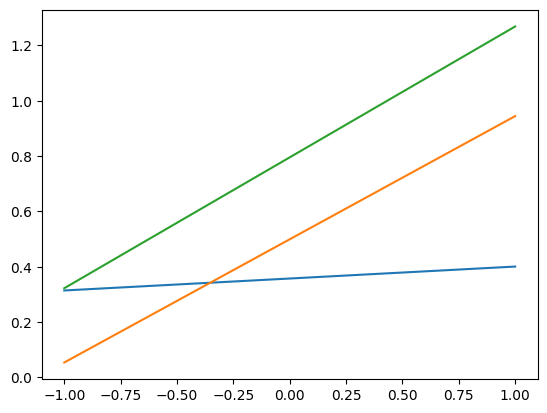

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-1.0, 1.0, num=100).reshape(-1,1)
W = np.random.rand(3,1)
b = np.random.rand(1,3)

h = X @ W.T + b

plt.plot(X.reshape(-1), h[:,0].reshape(-1), label='w1*x + b')
plt.plot(X.reshape(-1), h[:,1].reshape(-1), label='w2*x + b')
plt.plot(X.reshape(-1), h[:,2].reshape(-1), label='w3*x + b')
plt.show()


### Added stuff
- Now let's add a training loop here to observe each linear regions

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (1, n))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(net_sizes, key):
  keys = random.split(key, len(net_sizes))
  return [
     random_layer_params(m, n, k) 
     for (m,n), k in zip(net_sizes, keys)
   ]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



In [2]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input
    count = 0
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
        print(count)
        count += 1
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

In [3]:
import numpy as np
import math

def generate_sine_data(num_samples):
  X = jnp.linspace(0, 2 * math.pi, num=num_samples).reshape(-1,1)
  y = jnp.sin(X)
  return X,y

def update_weights(params, x, y, learning_rate):
  grads = grad(loss_func)(params, x, y)
  return [(w - learning_rate * dw, b - learning_rate * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(params, num_samples, num_epochs, step_display):
  learning_rate = 0.01
  X,y = generate_sine_data(num_samples)

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, X, y)
    params = update_weights(params, X, y, learning_rate)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  return params

def parameter_sizes(params):
  layer_depth = len(params)
  for layer_num, layer in enumerate(params, start=1):
    weight_dims = layer[0].shape
    bias_dims = layer[1].shape
    print('weights_dtype = ', layer[0].dtype)
    print('bias_dtype = ', layer[1].dtype)

    print(f'[{layer_num}/{layer_depth}] weight_dims = {weight_dims}, bias_dims = {bias_dims}')


In [19]:
import matplotlib.pyplot as plt

def plot_first_activations(params, X, epoch_round):

    linear_01 = X @ params[0][0] + params[0][1]
    activation = relu(linear_01)
    linear_01 = np.array(linear_01)
    activation = np.array(activation)
    
    # linear_02 = activation @ params[1][0] + params[1][1]
    # output = jnp.tanh(linear_02)

    linear_columns = linear_01.shape[1]
    fig, axs = plt.subplots(2, linear_columns, figsize=(15,5))
    # y_min = jnp.min(linear_01)
    # y_max = jnp.max(linear_01)

    y_min = -2 
    y_max = 2
    X_flat = X.reshape(-1)

    for linear_col in range(linear_columns):
        axs[0, linear_col].plot(X_flat, linear_01[:, linear_col].reshape(-1))
        axs[0, linear_col].set_ylim([y_min, y_max])
        axs[0, linear_col].set_title(f'linear @ epoch_round={epoch_round}')
        axs[0, linear_col].set_xlabel('X')
        axs[0, linear_col].set_ylabel('linear_01')
        axs[0, linear_col].set_xlim([0, 2 * math.pi])

        axs[1, linear_col].plot(X_flat, activation[:, linear_col])
        axs[1, linear_col].set_ylim([y_min, y_max])
        axs[1, linear_col].set_title(f'linear @ at epoch_round={epoch_round}')
        axs[1, linear_col].set_xlabel('X')
        axs[1, linear_col].set_ylabel('linear_01')
        axs[1, linear_col].set_xlim([0, 2 * math.pi])

    
    fig.suptitle('Yeah')
    plt.show()

    




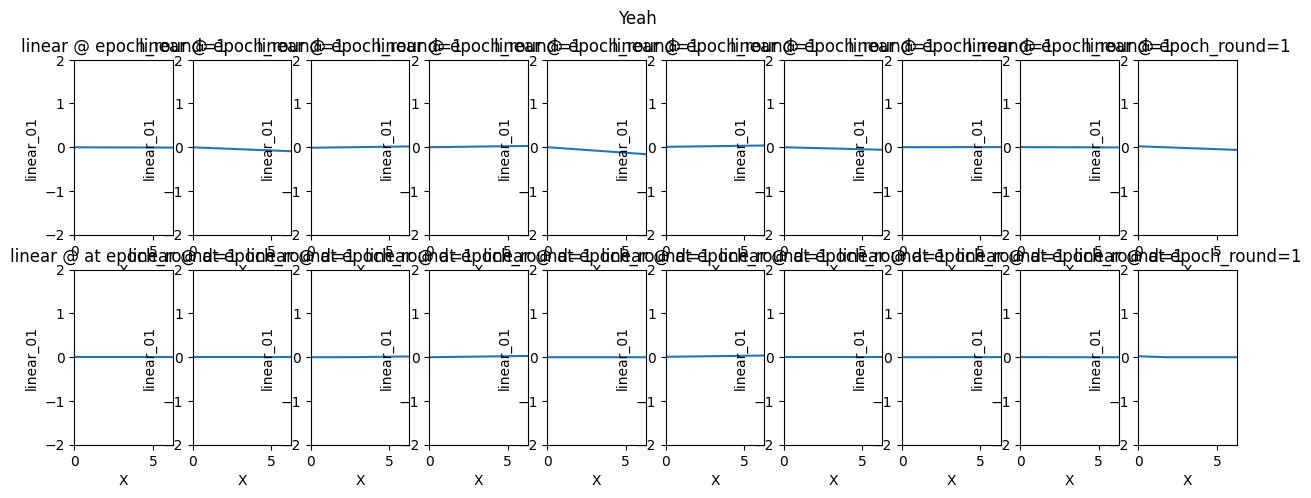

0
[10/1024] Loss: 0.49946966767311096
[20/1024] Loss: 0.499385803937912
[30/1024] Loss: 0.49928051233291626
[40/1024] Loss: 0.49913859367370605
[50/1024] Loss: 0.49893829226493835
[60/1024] Loss: 0.498649537563324
[70/1024] Loss: 0.4982289969921112
[80/1024] Loss: 0.49761396646499634
[90/1024] Loss: 0.49671420454978943
[100/1024] Loss: 0.4954017698764801
[110/1024] Loss: 0.49349868297576904
[120/1024] Loss: 0.4907655715942383
[130/1024] Loss: 0.4868968427181244
[140/1024] Loss: 0.4815341830253601
[150/1024] Loss: 0.47431471943855286
[160/1024] Loss: 0.464969277381897
[170/1024] Loss: 0.45345836877822876
[180/1024] Loss: 0.44008103013038635
[190/1024] Loss: 0.4254505932331085
[200/1024] Loss: 0.41029855608940125
[210/1024] Loss: 0.3952277600765228
[220/1024] Loss: 0.38059312105178833
[230/1024] Loss: 0.3665447235107422
[240/1024] Loss: 0.35312917828559875
[250/1024] Loss: 0.3403598964214325
[260/1024] Loss: 0.32824310660362244
[270/1024] Loss: 0.3167807459831238
[280/1024] Loss: 0.30596

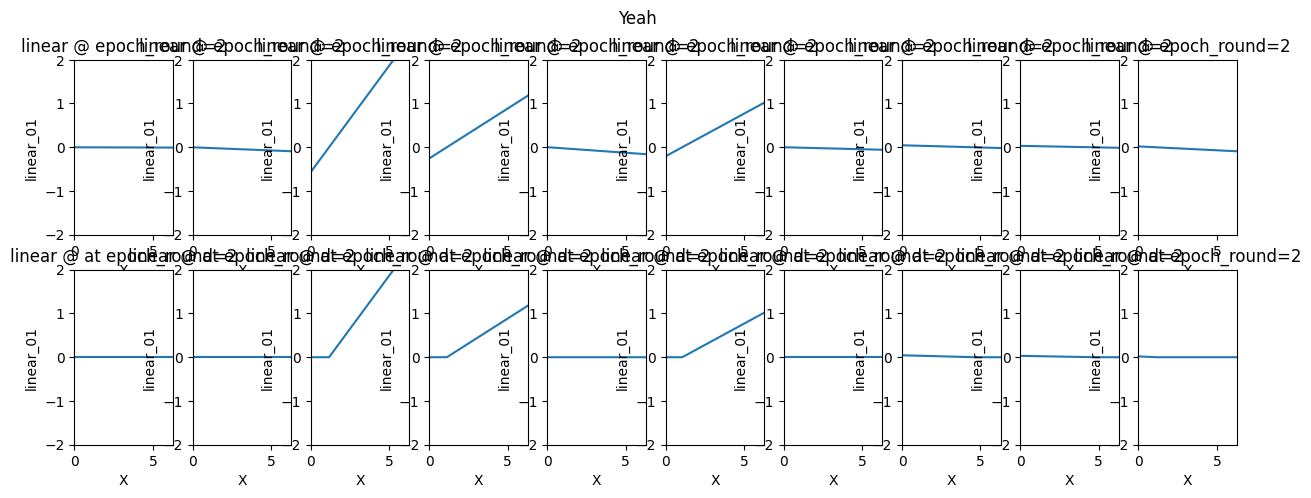

[10/1024] Loss: 0.11978594958782196
[20/1024] Loss: 0.1192994937300682
[30/1024] Loss: 0.11882327497005463
[40/1024] Loss: 0.11835700273513794
[50/1024] Loss: 0.11790026724338531
[60/1024] Loss: 0.11745279282331467
[70/1024] Loss: 0.11701436340808868
[80/1024] Loss: 0.11658478528261185
[90/1024] Loss: 0.11616374552249908
[100/1024] Loss: 0.1157509833574295
[110/1024] Loss: 0.11534622311592102
[120/1024] Loss: 0.11494925618171692
[130/1024] Loss: 0.11455991119146347
[140/1024] Loss: 0.11417803168296814
[150/1024] Loss: 0.11380336433649063
[160/1024] Loss: 0.11343568563461304
[170/1024] Loss: 0.11307480931282043
[180/1024] Loss: 0.11272057890892029
[190/1024] Loss: 0.11237282305955887
[200/1024] Loss: 0.11203137785196304
[210/1024] Loss: 0.11169604957103729
[220/1024] Loss: 0.11136674880981445
[230/1024] Loss: 0.11104326695203781
[240/1024] Loss: 0.1107255220413208
[250/1024] Loss: 0.1104133129119873
[260/1024] Loss: 0.11010652780532837
[270/1024] Loss: 0.10980503261089325
[280/1024] Los

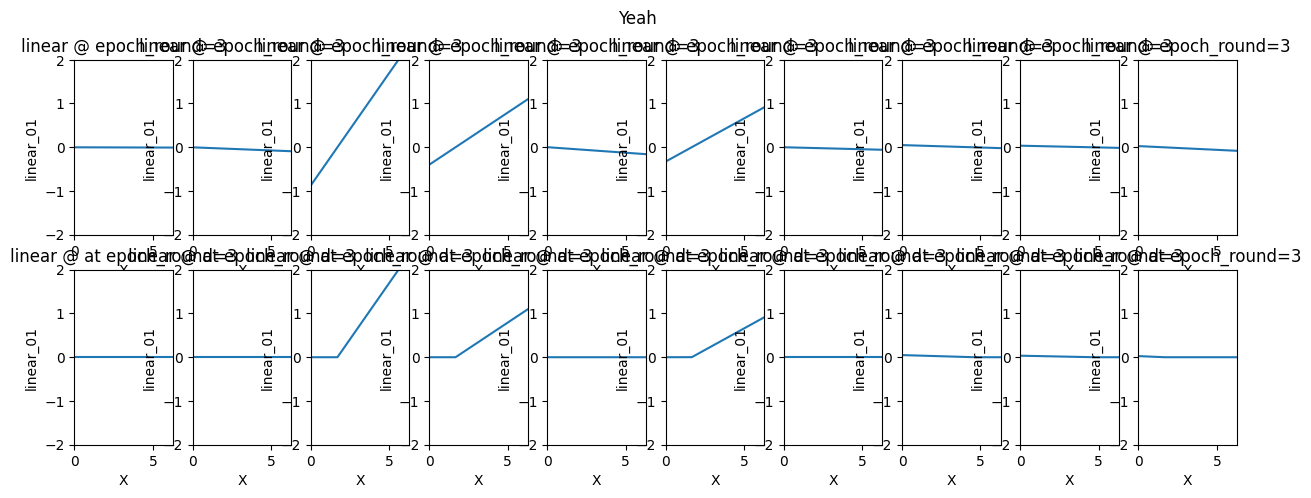

[10/1024] Loss: 0.09635849297046661
[20/1024] Loss: 0.09625974297523499
[30/1024] Loss: 0.09616201370954514
[40/1024] Loss: 0.0960657149553299
[50/1024] Loss: 0.09597036242485046
[60/1024] Loss: 0.09587649255990982
[70/1024] Loss: 0.09578348696231842
[80/1024] Loss: 0.09569187462329865
[90/1024] Loss: 0.0956011563539505
[100/1024] Loss: 0.09551174193620682
[110/1024] Loss: 0.09542323648929596
[120/1024] Loss: 0.095335952937603
[130/1024] Loss: 0.09524963796138763
[140/1024] Loss: 0.09516441822052002
[150/1024] Loss: 0.0950801745057106
[160/1024] Loss: 0.09499698877334595
[170/1024] Loss: 0.09491478651762009
[180/1024] Loss: 0.09483359754085541
[190/1024] Loss: 0.09475329518318176
[200/1024] Loss: 0.09467406570911407
[210/1024] Loss: 0.09459567815065384
[220/1024] Loss: 0.09451834857463837
[230/1024] Loss: 0.0944417417049408
[240/1024] Loss: 0.09436628967523575
[250/1024] Loss: 0.09429147839546204
[260/1024] Loss: 0.09421779215335846
[270/1024] Loss: 0.0941447764635086
[280/1024] Loss: 

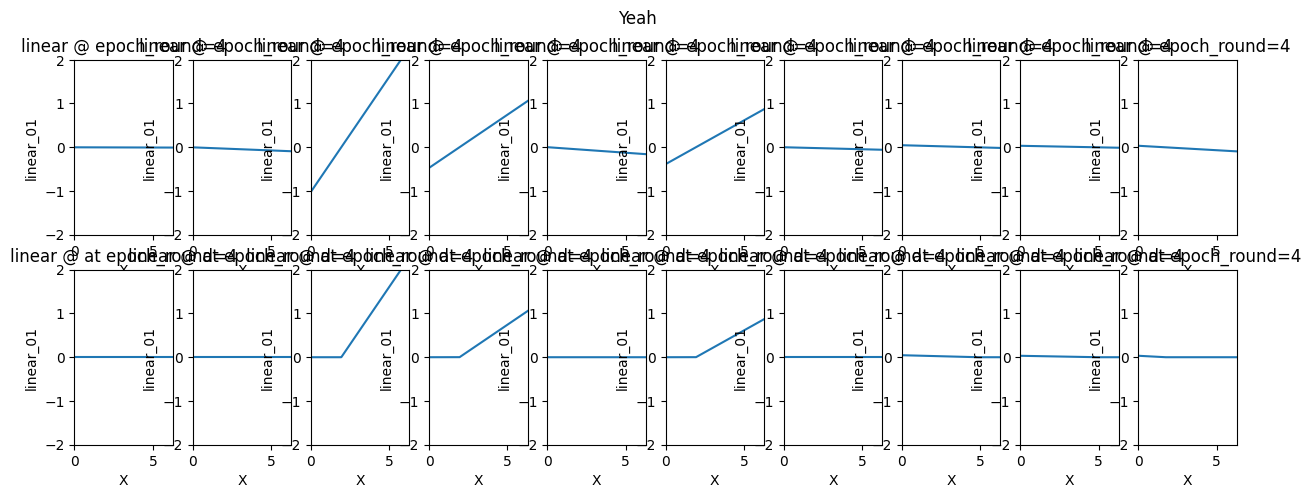

[10/1024] Loss: 0.09044508635997772
[20/1024] Loss: 0.09041433781385422
[30/1024] Loss: 0.09038379788398743
[40/1024] Loss: 0.09035356342792511
[50/1024] Loss: 0.09032382071018219
[60/1024] Loss: 0.09029430896043777
[70/1024] Loss: 0.09026499092578888
[80/1024] Loss: 0.09023606032133102
[90/1024] Loss: 0.09020751714706421
[100/1024] Loss: 0.0901791900396347
[110/1024] Loss: 0.09015103429555893
[120/1024] Loss: 0.09012333303689957
[130/1024] Loss: 0.09009595215320587
[140/1024] Loss: 0.0900687575340271
[150/1024] Loss: 0.09004172682762146
[160/1024] Loss: 0.09001515805721283
[170/1024] Loss: 0.08998889476060867
[180/1024] Loss: 0.08996278792619705
[190/1024] Loss: 0.08993684500455856
[200/1024] Loss: 0.08991134166717529
[210/1024] Loss: 0.0898861363530159
[220/1024] Loss: 0.08986108750104904
[230/1024] Loss: 0.08983619511127472
[240/1024] Loss: 0.08981167525053024
[250/1024] Loss: 0.08978748321533203
[260/1024] Loss: 0.08976344764232635
[270/1024] Loss: 0.08973956108093262
[280/1024] Lo

In [21]:
# Network initial parameters
num_hidden = 10
net_sizes = [
  (1, num_hidden),
  (num_hidden, 1),
]

random_seed = np.random.randint(0, 1024)
params = init_network_params(net_sizes, random.PRNGKey(random_seed))

current_epoch = 0
epoch_per_round = 1024
total_epoch_rounds = 5
num_training_samples = 1024
step_display = 10

for epoch_round in range(1, total_epoch_rounds):
    plot_first_activations(params, X_test, epoch_round)
    params = train_network(params, num_training_samples, epoch_per_round, step_display)
    X_test, y_test = generate_sine_data(256)
    # X_test, y_test = generate_sine_data(256)
    # y_pred = predict(params, X_test)
    # loss = loss_func(params, X_test, y_test)
    # print(f'[{epoch_round}]/{total_epoch_rounds} loss = {loss}')
    
     

In [40]:
X_test, y_test = generate_sine_data(512)



### Part 1
- Plot each linear component of initial layer.


### Sample Supblot Code

```python

import matplotlib.pyplot as plt


# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plotting
# Plotting with y-axis limits set

y_min = np.min(y)
y_max = np.max(y)

axs[0].plot(X_flat, y[:, 0], color='green')
axs[0].set_ylim([y_min, y_max])
axs[0].set_title('y = b_00 + w_00 * x')
axs[0].set_xlabel('X input')
axs[0].set_ylabel('y')
axs[0].set_xlim([-1, 1])

axs[1].plot(X_flat, y[:, 1], color='gray')
axs[1].set_ylim([y_min, y_max])
axs[1].set_title('y = b_01 + w_01 * x')
axs[1].set_xlabel('X input')
axs[1].set_xlim([-1, 1])

axs[2].set_xlabel('X input')
axs[2].plot(X_flat, -(y[:, 0] + y[:, 1])/2, color='black')
axs[2].set_ylim([y_min, y_max])
axs[2].set_title('y = b_02 + w_02 * x')
axs[2].set_xlim([-1, 1])

# Display the plot
fig.suptitle('Sublinear Components of Shallow Networks')
plt.show()

```